In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [5]:
H5AD_FILE = "../../../data/mouse_adrenal/preprocessed/snrna/adrenal_Parse_10x_integrated_RNA.h5ad"

In [6]:
adata = sc.read_h5ad(H5AD_FILE)

In [7]:
adata

AnnData object with n_obs × n_vars = 79209 × 47721
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellID', 'doublet_scores', 'doublets', 'library_accession', 'technology', 'species', 'tissue', 'sex', 'timepoint', 'rep', 'sample', 'depth1', 'depth2', 'experiment', 'experiment_batch', 'integration_batch', 'run_number', 'experiment_accession', 'file_accession', 'lower_nCount_RNA', 'upper_nCount_RNA', 'lower_nFeature_RNA', 'upper_doublet_scores', 'upper_percent.mt', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.6', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'subtypes', 'celltypes', 'gen_celltype', 'Cortex_membership_score', 'Endothelial_membership_score', 'Adipocytes_membership_score', 'Myeloid_membership_score', 'Sox10._membership_score', 'Fibroblast_membership_score', 'Medulla_membership_score', 'Stromal_membership_score', 'Smooth_muscle_membership_score', 'Capsule_membership_score', 'Hepatocyte_membership_score', 'Myonuclei_membership_

# Summarize the data

In [10]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  16587565.96689
Number of cells in which each gene is detected: 0  -  79208


In [11]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  2376.27
minSamples:  792.09


In [12]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please ada

Text(0.5, 0.0, 'Genes expressed per cell')

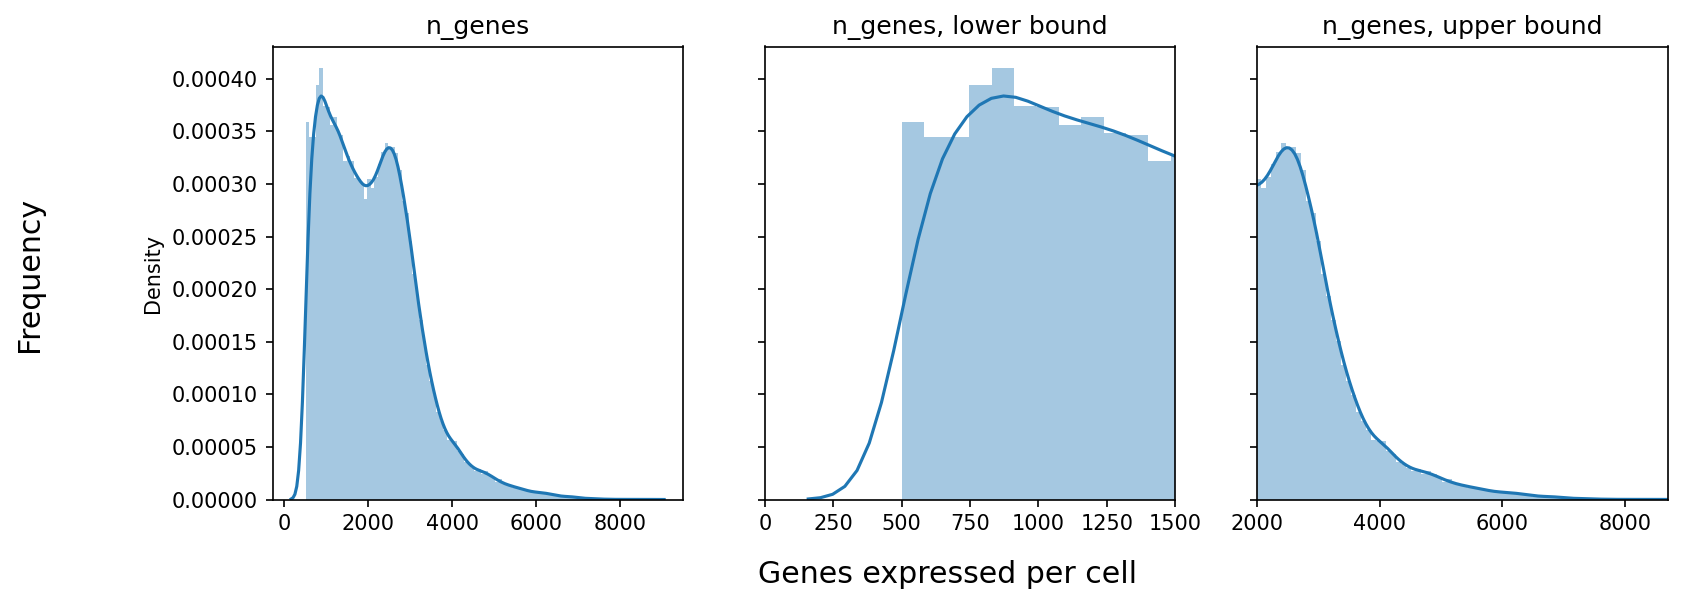

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
    ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for hi

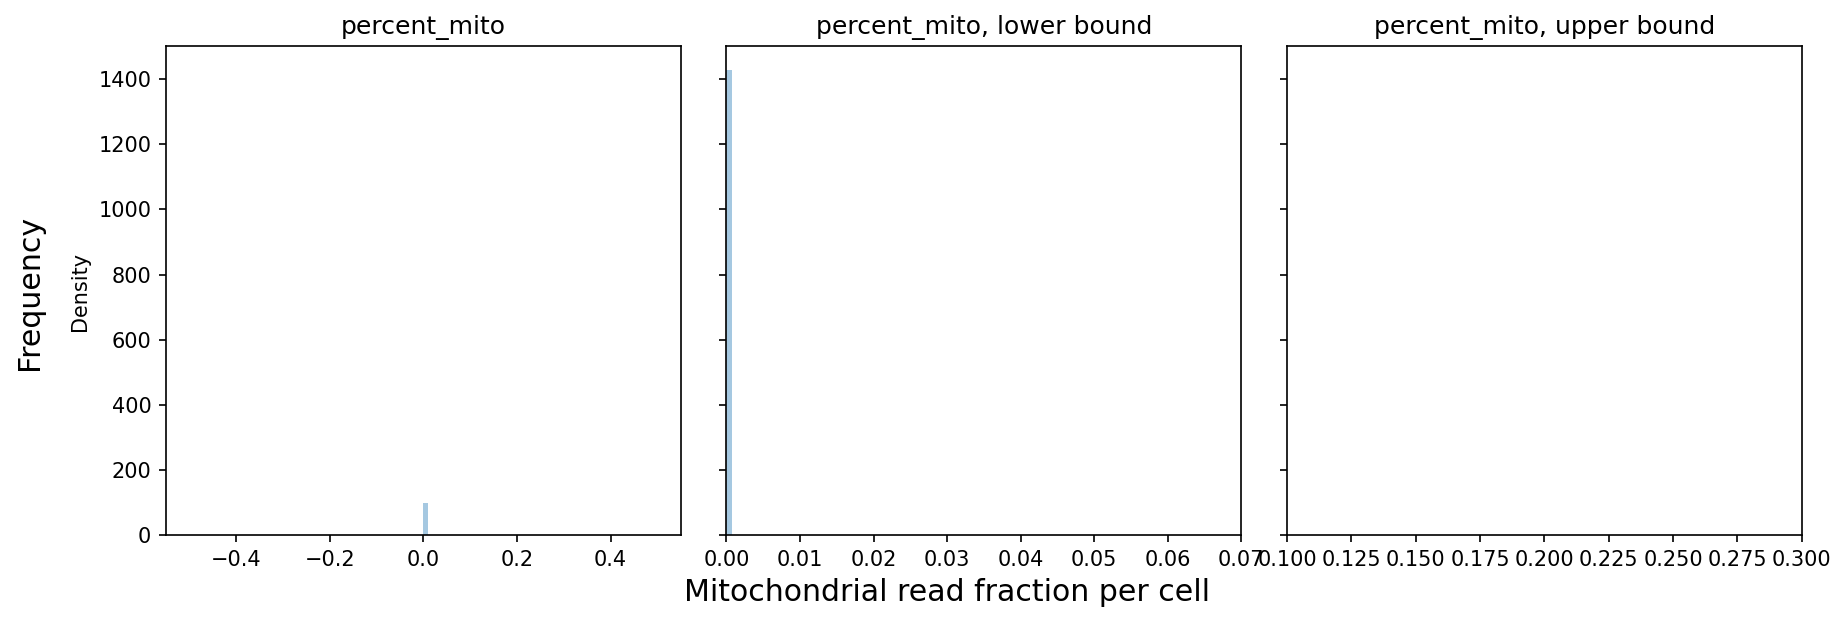

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
    ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please ada

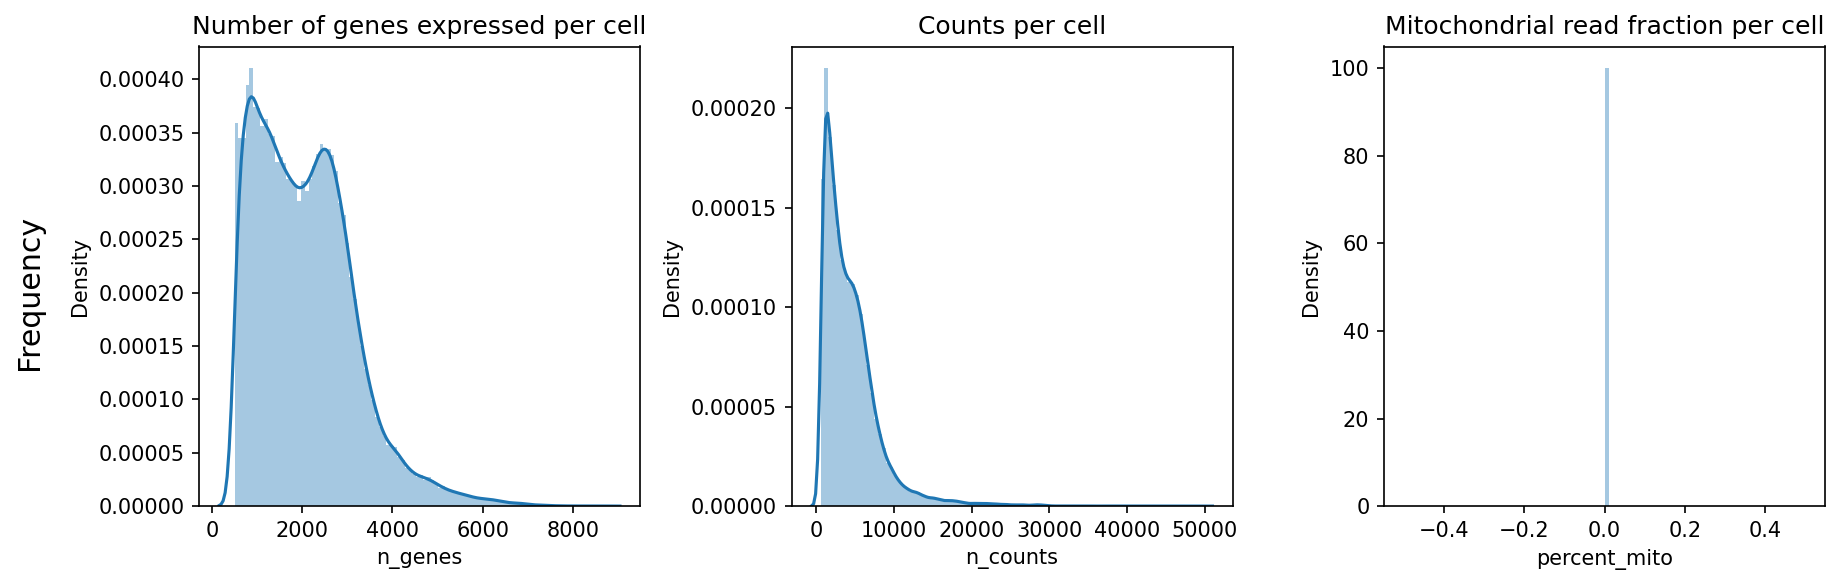

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

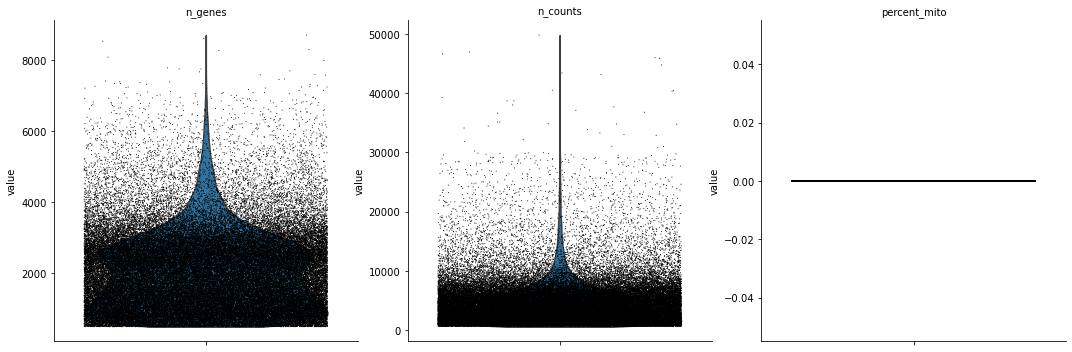

In [20]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

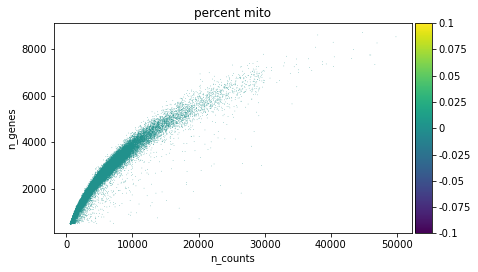

In [21]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

# Filtering
Description

In [22]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3)

In [23]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please ada

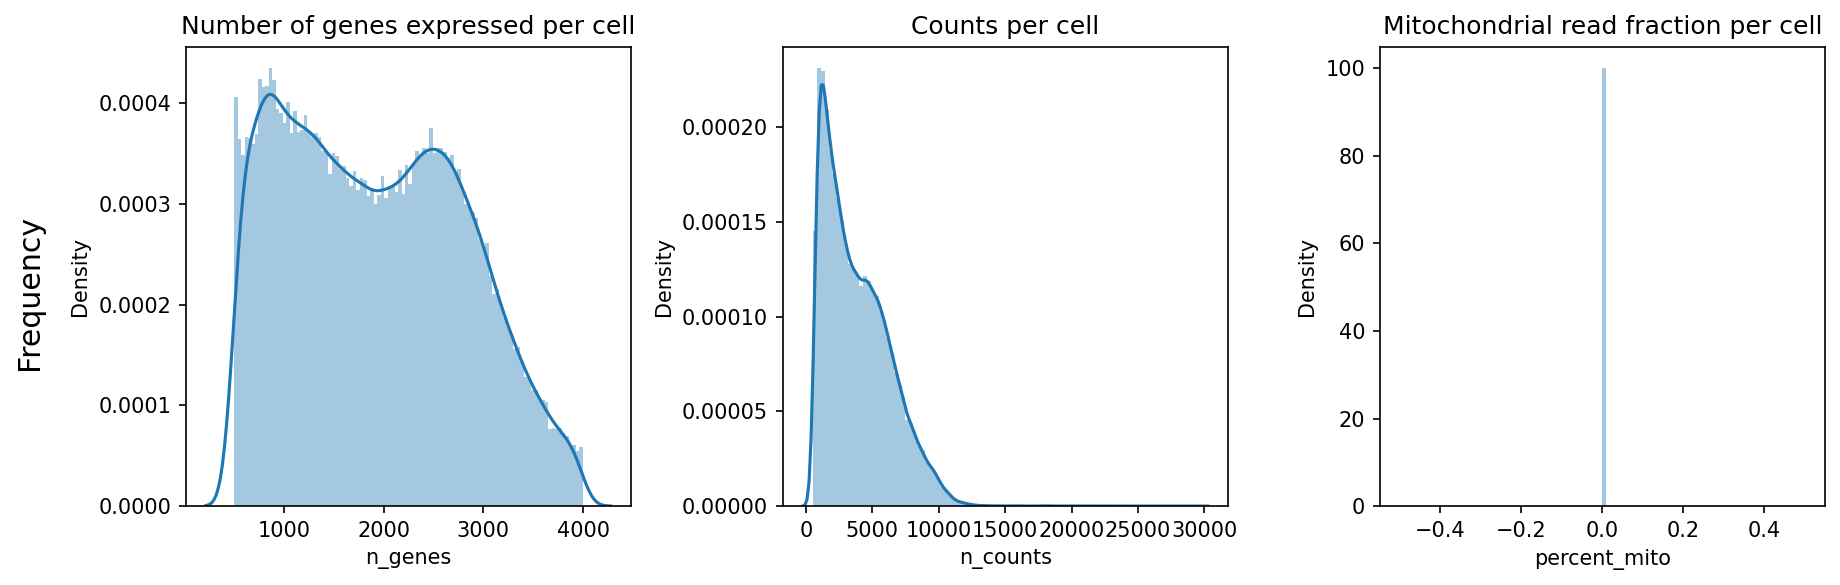

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

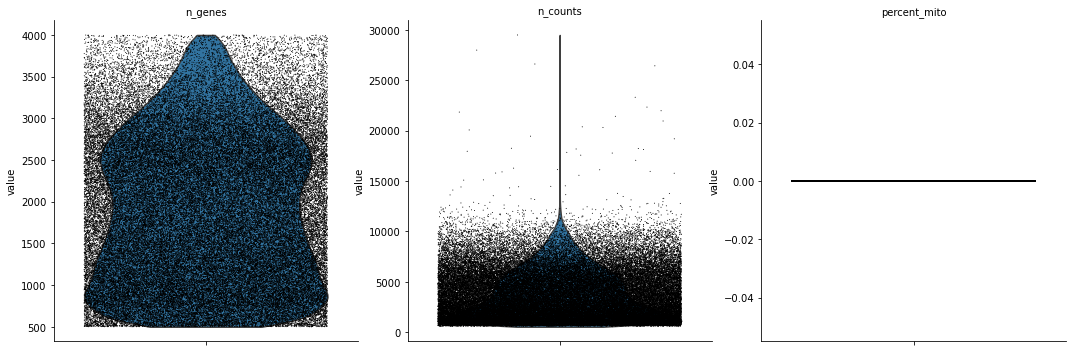

In [25]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

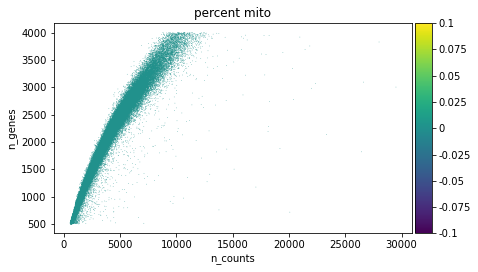

In [27]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [28]:
import loompy as lp
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create("../../../data/mouse_adrenal/preprocessed/snrna/adrenal_Parse_10x_integrated_RNA.loom", adata.X.transpose(), row_attrs, col_attrs)

In [29]:
adata_subset = sc.pp.subsample(adata, n_obs=1000, copy=True, random_state=13)

In [31]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata_subset.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata_subset.obs_names) ,
    "nGene": np.array( np.sum(adata_subset.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_subset.X.transpose() , axis=0)).flatten() ,
}
lp.create("../../../data/mouse_adrenal/preprocessed/snrna/adrenal_Parse_10x_integrated_RNA_subset.loom", adata_subset.X.transpose(), row_attrs, col_attrs)

# SCENIC

STEP 1: Gene regulatory network inference, and generation of co-expression modules
Phase Ia: GRN inference using the GRNBoost2 algorithm
For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier. Output: List of adjacencies between a TF and its targets stored in ADJACENCIES_FNAME.

In [ ]:
%%bash
source activate scverse-py38
pyscenic grn data/adrenal_Parse_10x_integrated_RNA_subset.loom data/25_tfs.txt -o result/25_tf_subset_adj.tsv --num_workers 8

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.

2022-12-08 09:50:03,907 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-12-08 09:50:05,734 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork fro

STEP 2-3: Regulon prediction aka cisTarget from CLI
For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

Output: List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

locations for ranking databases, and motif annotations:

In [155]:
%%bash
source activate single_cell_py
pyscenic ctx adj.tsv \
    ../hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather \
    --annotations_fname ../motifs-v9-nr.hgnc-m0.001-o0.0.tbl \
    --expression_mtx_fname pbmc10k_filtered_scenic.loom \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 16

[########################################] | 100% Completed | 44.6s



2022-02-16 16:56:07,341 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-02-16 16:56:07,354 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-16 16:56:12,765 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-02-16 16:56:12,769 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2022-02-16 16:56:13,096 - pyscenic.utils - INFO - Creating modules.

2022-02-16 16:56:14,248 - pyscenic.cli.pyscenic - IN

STEP 4: Cellular enrichment (aka AUCell) from CLI
It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

In [156]:
%%bash
source activate single_cell_py
pyscenic aucell \
    pbmc10k_filtered_scenic.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 20

Create regulons from a dataframe of enriched features.
Additional columns saved: []



2022-02-16 16:59:46,516 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-16 16:59:52,708 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2022-02-16 16:59:52,778 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2022-02-16 17:00:02,294 - pyscenic.cli.pyscenic - INFO - Writing results to file.


---

# Scratch